# Credit card fraud detection Kaggle dataset

* https://www.kaggle.com/mlg-ulb/creditcardfraud/version/3

Code which inspired this notebook:
* https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now
* http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/combine/plot_smote_enn.html#sphx-glr-auto-examples-combine-plot-smote-enn-py

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import pickle
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

#for logistic regression and over sampling
#cc = !nproc
cc = !sysctl -n hw.ncpu
cc = int(cc[0])

%matplotlib inline

In [22]:
# timing helper functions

def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

In [24]:
# set up parallel cluster using ipyparallel engines.
# ipcluster start
import ipyparallel as ipp
from ipyparallel import require
c = ipp.Client(profile='default')
v = c[:]
#print("engines running:",v)
print("engines running:",len(v))

engines running: 4


/Users/scheckley/anaconda3/lib/python3.6/site-packages/ipyparallel/util.py:208: RuntimeWarning: IPython could not determine IPs for vii19567: [Errno 8] nodename nor servname provided, or not known
  RuntimeWarning)
/Users/scheckley/anaconda3/lib/python3.6/site-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@vii19567')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


## Load the data and clean it up

In [25]:
data = pd.read_csv("data/creditcard.csv")
data.shape

(284807, 31)

In [26]:
normamount = np.array(data['Amount'])
normamount = StandardScaler().fit_transform(normamount.reshape(-1,1))
data['normamount'] = normamount
del data['Amount']
del data['Time']
data = shuffle(data)
data.head(10)
data.shape

(284807, 30)

Elapsed time is 0.7112739086151123 seconds.


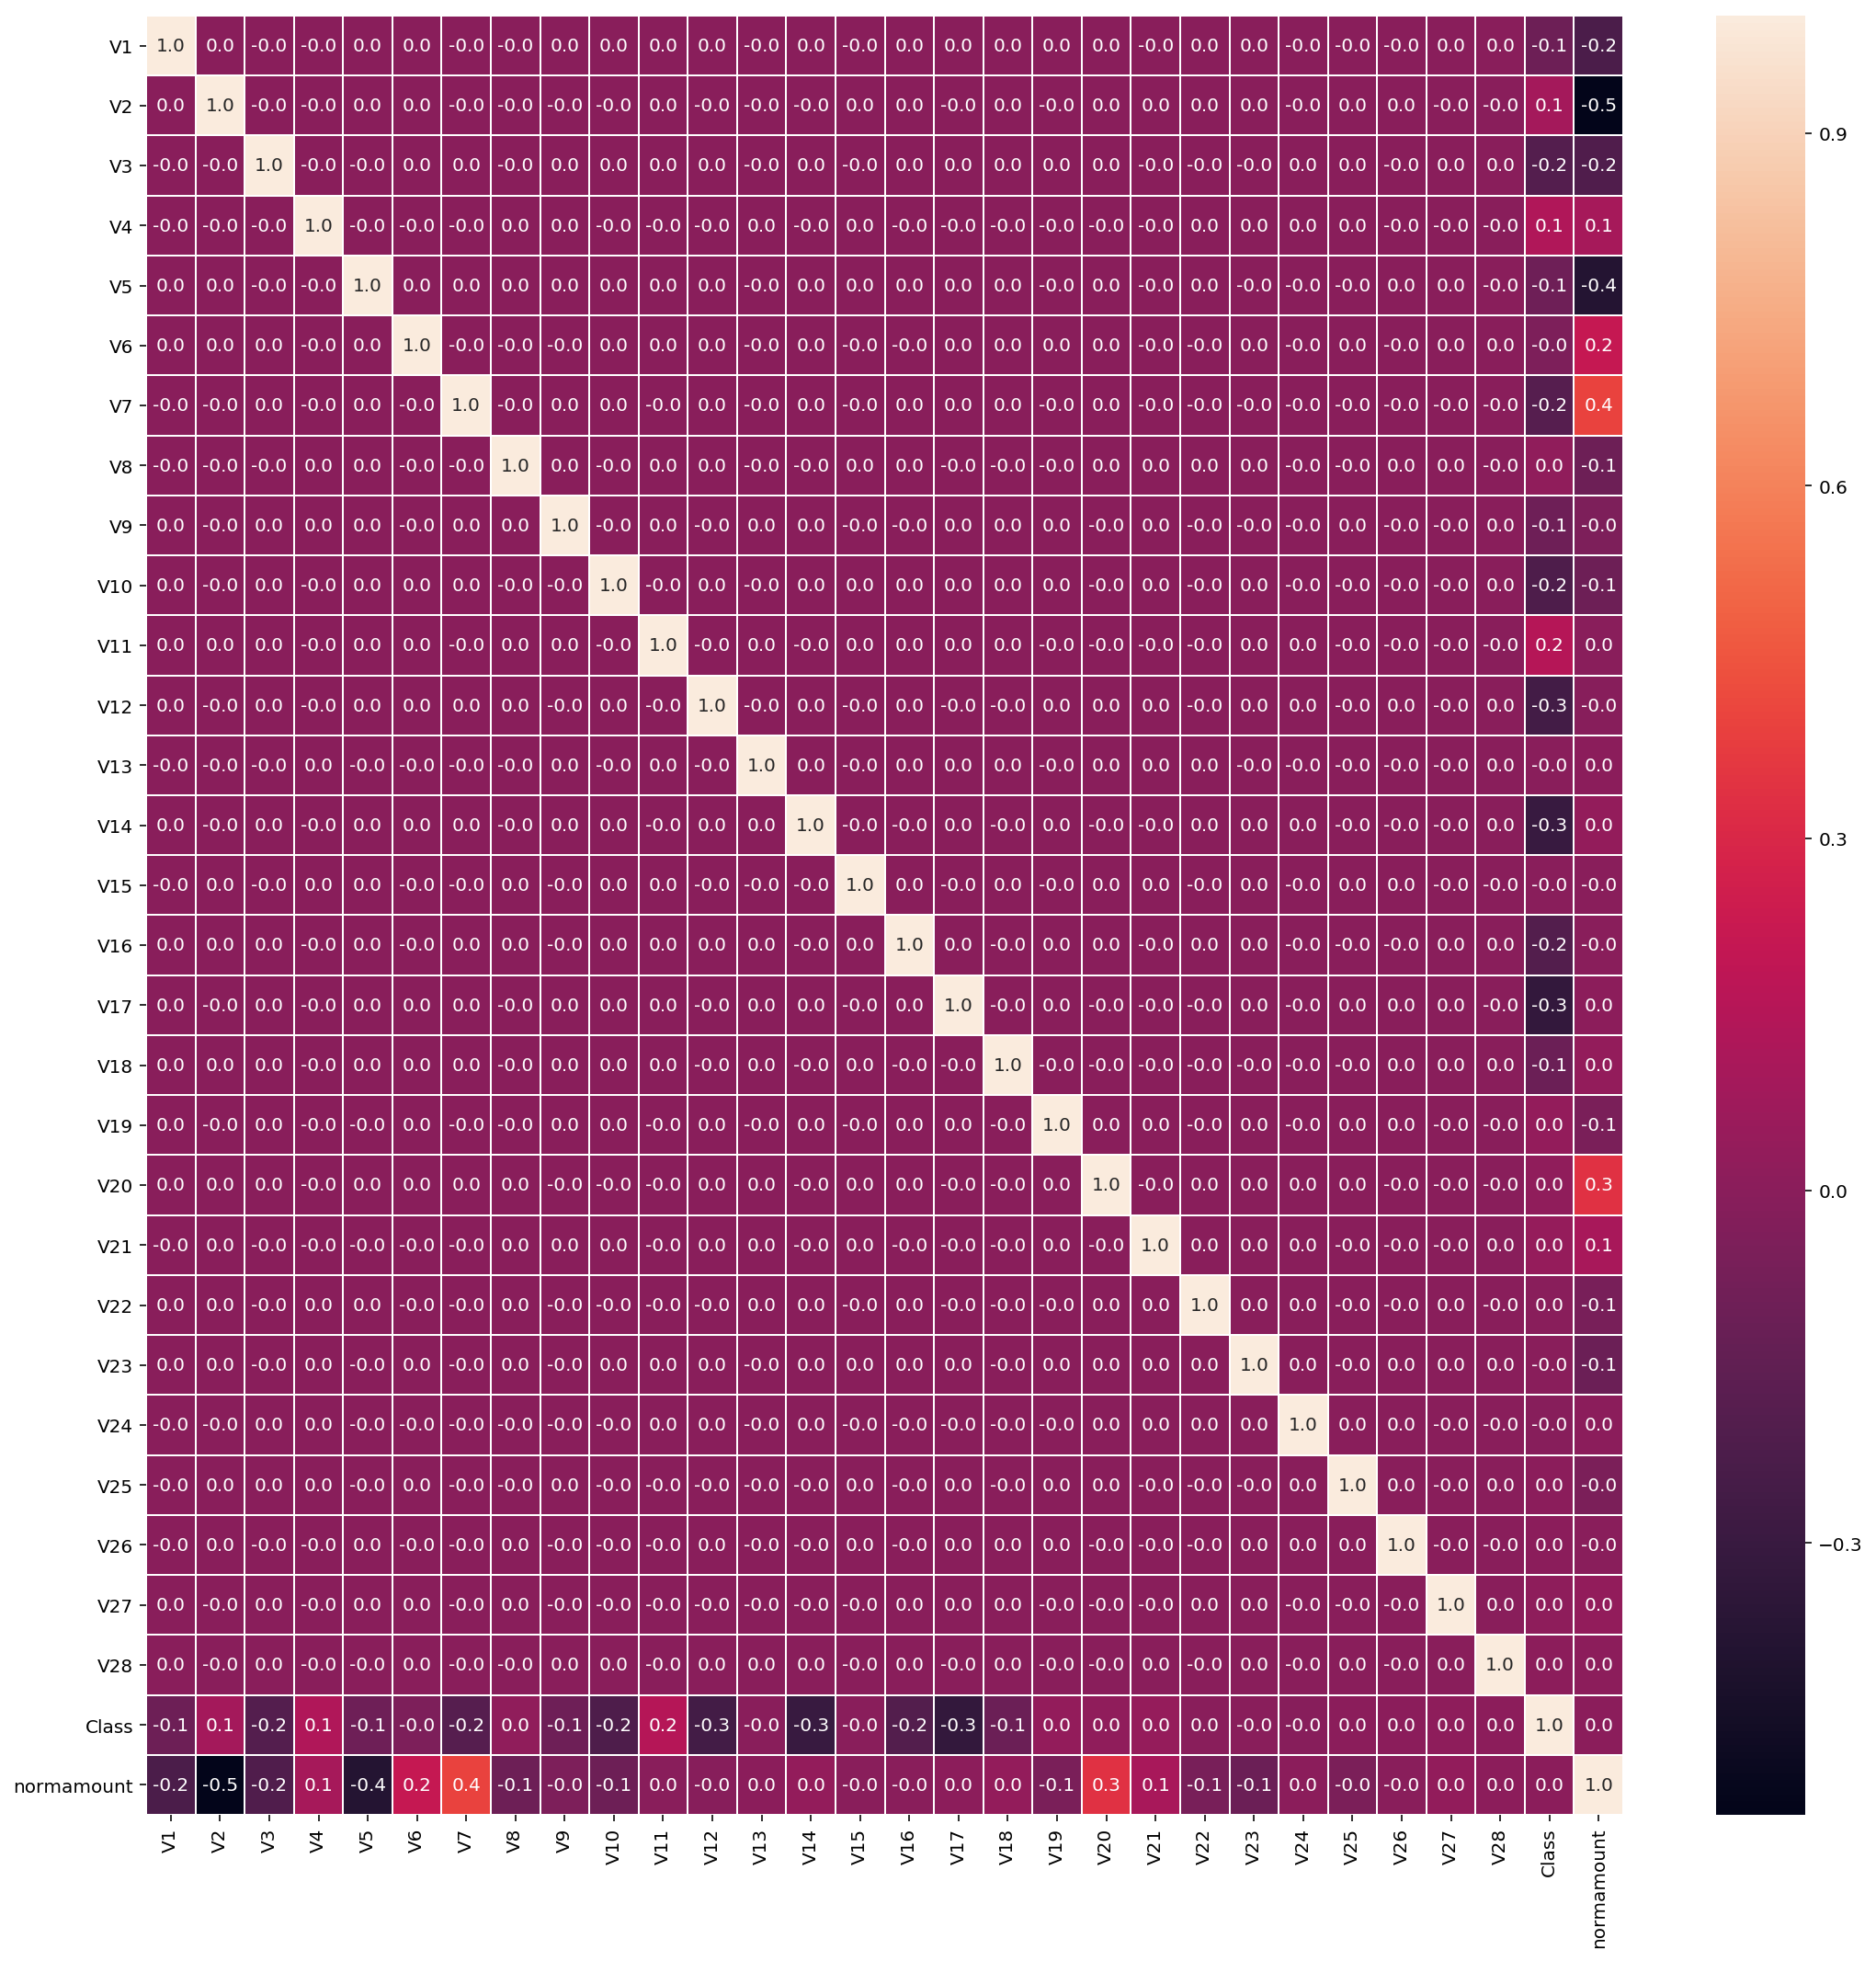

In [27]:
# heat map to look for correlation
tic()
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);
toc()

low correlation between features in this dataset.

In [28]:
#look at class imbalance
by_class = data.groupby('Class')
by_class.describe()

V1                                        V10       ...    V9  \
         count mean std   min  25%  50%  75% max    count mean  ...   75%   
Class                                                           ...         
0     284315.0  0.0 1.9 -56.4 -0.9  0.0  1.3 2.5 284315.0  0.0  ...   0.6   
1        492.0 -4.8 6.8 -30.6 -6.0 -2.3 -0.4 2.1    492.0 -5.7  ...  -0.8   

           normamount                                     
       max      count mean std  min  25%  50%  75%   max  
Class                                                     
0     15.6   284315.0 -0.0 1.0 -0.4 -0.3 -0.3 -0.0 102.4  
1      3.4      492.0  0.1 1.0 -0.4 -0.3 -0.3  0.1   8.1  

[2 rows x 232 columns]

The data appears to be quite heavily imbalanced as (obviously), fraudulent transactions should be relatively rare!

Can I use over sampling to improve the balance of the data?

In [29]:
# http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.combine.SMOTEENN.html
# http://contrib.scikit-learn.org/imbalanced-learn/stable/combine.html#combine
from imblearn.over_sampling import ADASYN#SMOTE
sm = ADASYN(n_jobs=cc)

In [30]:
# split the features and target vector for resampling
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X)

In [32]:
X.columns = X.columns.astype(str)
y.columns = y.columns.astype(str)

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

In [34]:
#resmaple just the training data and leave the test data untouched
tic()
#X_train_resampled, y_train_resampled = sm.fit_sample(X_train, y_train)
toc()
# this step takes a bit of time so I pickled the output

Elapsed time is 2.6941299438476562e-05 seconds.


In [35]:
#pickle.dump(X_train_resampled, open( "X_train_resampled.pkl", "wb" ))
#pickle.dump(y_train_resampled, open( "y_train_resampled.pkl", "wb" ))

In [36]:
X_train_resampled = pickle.load(open( "X_train_resampled.pkl", "rb" ))
y_train_resampled = pickle.load(open( "y_train_resampled.pkl", "rb" ))

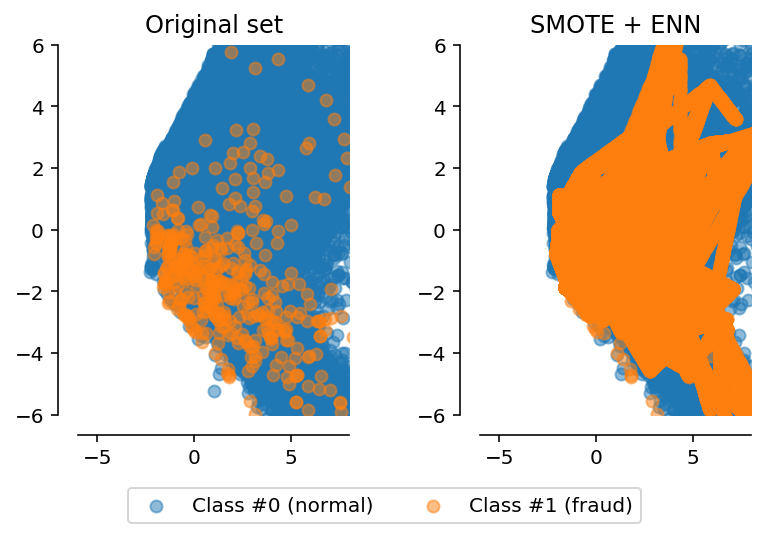

In [17]:
X_res_vis = pca.transform(X_train_resampled)

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2)

c0 = ax1.scatter(X_vis[y['Class'] == 0, 0], X_vis[y['Class'] == 0, 1], label="Class #0",
                 alpha=0.5)
c1 = ax1.scatter(X_vis[y['Class'] == 1, 0], X_vis[y['Class'] == 1, 1], label="Class #1",
                 alpha=0.5)
ax1.set_title('Original set')

ax2.scatter(X_res_vis[y_train_resampled == 0, 0], X_res_vis[y_train_resampled == 0, 1],
            label="Class #0", alpha=0.5)
ax2.scatter(X_res_vis[y_train_resampled == 1, 0], X_res_vis[y_train_resampled == 1, 1],
            label="Class #1", alpha=0.5)
ax2.set_title('SMOTE + ENN')

# make nice plotting
for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([-6, 8])
    ax.set_ylim([-6, 6])

f.legend((c0, c1), ('Class #0 (normal)', 'Class #1 (fraud)'), loc='lower center',
         ncol=2, labelspacing=0.)
plt.tight_layout(pad=3)
plt.show()

Prep the new resampled data for machine learning

In [18]:
#from sklearn.manifold import TSNE

In [166]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,test_size = 0.3, random_state = 0)

In [40]:
#t-SNE
#model = TSNE(n_components=2, verbose=0, n_iter=300)
#t = model.fit_transform(X) #(X_resampled)

In [42]:
#pickle.dump(t, open( "tsne_model.pkl", "wb" ))

In [45]:
#t = pickle.load(open( "tsne_model.pkl", "rb" ))
#df_tsne = pd.DataFrame()
#df_tsne['x-tsne'] = t[:,0]
#df_tsne['y-tsne'] = t[:,1]
#df_tsne['target'] = y

#df_tsne2 = df_tsne.head(5000)

#colors = np.where(df_tsne.target > 0, 'r', 'b')

#df_tsne2.plot.scatter(x='x-tsne',y='y-tsne', c=colors,s=1)

In [37]:
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
from sklearn.externals import joblib #for saving the trained model

In [22]:
#lr = LogisticRegression(C = 0.01, penalty = 'l1')
#lr.fit(X_train,y_train)
#y_pred = lr.predict(X_test)

### Logistic Regression

In [50]:
# try a grid search to find best parameters
from sklearn.model_selection import GridSearchCV
tic()
lr = LogisticRegression(C = 0.01, penalty = 'l1')# , solver='liblinear')
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}#[0.001,0.01,0.1,1,10,100]}
lr = GridSearchCV(lr, param_grid=grid_values, n_jobs=cc)
lr.fit(X_train_resampled,y_train_resampled)
print(lr.best_params_)

y_pred = lr.predict(X_test)
toc()

# Result: 0.97 with gridsearch finding l2 penalty and C=0.01.

{'C': 0.01, 'penalty': 'l2'}
Elapsed time is 427.5883598327637 seconds.


In [134]:
#lr_best = LogisticRegression(C=lr.best_params_['C'], penalty=lr.best_params_['penalty'], solver='lbfgs', n_jobs=cc)
#lr_best.fit(X_train, y_train)
#y_pred = lr_best.predict(X_test)

In [51]:
# confusion matrix plotting function
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the testing dataset:  0.9681528662420382


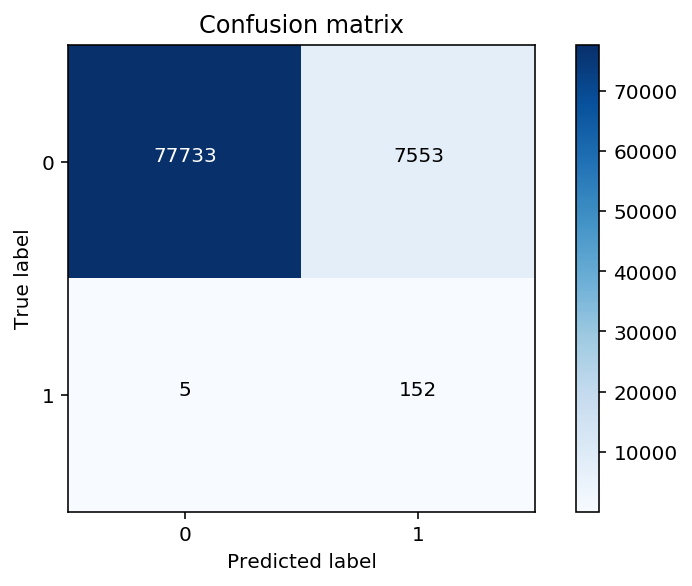

In [52]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [55]:
#save the model
joblib.dump(lr, 'lr_model.pkl')

['lr_model.pkl']

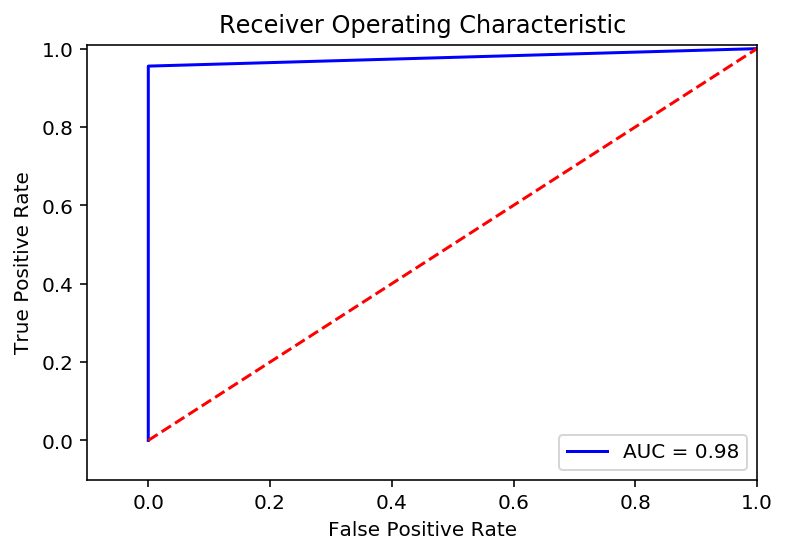

In [64]:
# ROC curve
#lr = LogisticRegression(C = 10, penalty = 'l2')
y_pred_score = lr.fit(X_train_resampled,y_train_resampled).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib #for saving the trained model

In [30]:
# try a grid search to find best parameters
from sklearn.model_selection import GridSearchCV
tic()
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=4)
grid_values = {'n_estimators': [10,100,200,500,1000]}

#initially training was done using a grid search to find the best number of estimators
#rf = GridSearchCV(rf, param_grid=grid_values, n_jobs=cc)

# for time here, I'm retraining using the optimum I found which was 1000.
#RandomForestClassifier(n_estimators=1000, oob_score=True, n_jobs=4)

rf.fit(X_train_resampled,y_train_resampled)

y_pred = rf.predict(X_test)
toc()

print(rf.best_params_)

Elapsed time is 0.3012349605560303 seconds.


In [33]:
#save the model
#joblib.dump(rf, 'rf_model.pkl')

['rf_model.pkl']

In [71]:
#load the model
rf = joblib.load('rf_model.pkl') 
y_pred = rf.predict(X_test)

Recall metric in the testing dataset:  0.9554140127388535


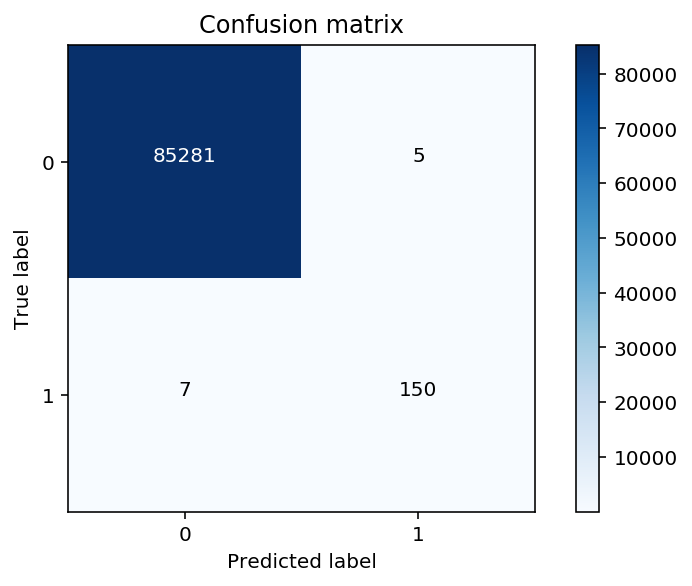

In [69]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

# best recall metric = 0.96 with n_estimators=1000

In [ ]:
# ROC curve

#load the model from pickle rather than re-train
rf = joblib.load('rf_model.pkl')
#rf = RandomForestClassifier(n_estimators=1000, oob_score=True, n_jobs=4)
#y_pred_score = rf.fit(X_train_resampled,y_train_resampled).predict_proba(X_test)


y_pred_score = rf.fit(X_train_resampled,y_train_resampled).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### calculate CI on RF
* http://contrib.scikit-learn.org/forest-confidence-interval/auto_examples/plot_spam.html#sphx-glr-auto-examples-plot-spam-py

In [44]:
import forestci as fci #note - requires duecredit package

In [45]:
rf = joblib.load('rf_model.pkl') 

In [46]:
fraud_y_hat = rf.predict_proba(X_test)

idx_fraud = np.where(y_test == 1)[0]
idx_notfraud = np.where(y_test == 0)[0]

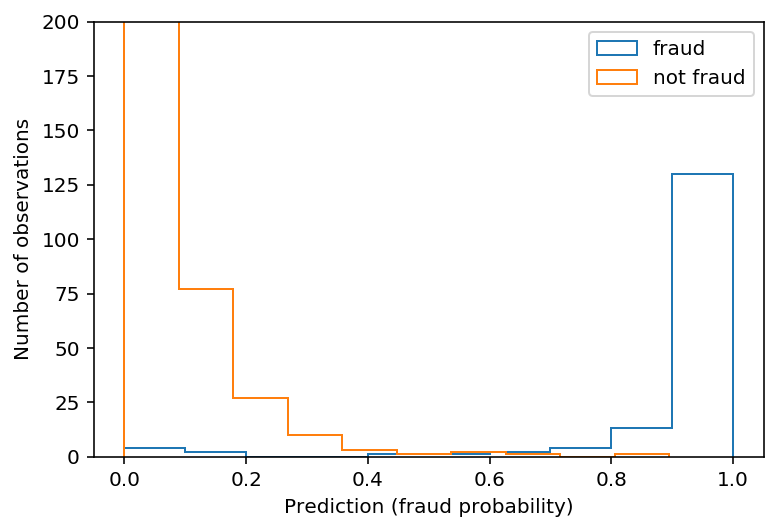

In [49]:
# Histogram predictions without error bars:
fig, ax = plt.subplots(1)
ax.hist(fraud_y_hat[idx_fraud, 1], histtype='step', label='fraud')
ax.hist(fraud_y_hat[idx_notfraud, 1], histtype='step', label='not fraud')
ax.set_xlabel('Prediction (fraud probability)')
ax.set_ylabel('Number of observations')
ax.set_ylim([0, 200])
plt.legend();

## Tensor flow - 'cos everybody loves a neural network!

https://github.com/aaxwaz/Fraud-detection-using-deep-learning/blob/master/auto-encoder/autoencoder_demo.ipynb

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from datetime import datetime 
from sklearn.metrics import roc_auc_score as auc 
import seaborn as sns
import pickle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [14]:
# little script to automatically assign feature columns for Tensorflow as strings or ints.
#import pandas.api.types as ptypes

#my_columns = []

#for col in my_features.columns:
#  if ptypes.is_string_dtype(my_features[col]): #is_string_dtype is pandas function
#    my_columns.append(tf.feature_column.categorical_column_with_hash_bucket(col, 
#        hash_bucket_size= len(my_features[col].unique())))

#  elif ptypes.is_numeric_dtype(my_features[col]): #is_numeric_dtype is pandas function
#    my_columns.append(tf.feature_column.numeric_column(col))

In [15]:
# Parameters
learning_rate = 0.001
training_epochs = 20
batch_size = 256
display_step = 1

# Network Parameters
n_hidden_1 = 15 # 1st layer num features
#n_hidden_2 = 15 # 2nd layer num features
n_input = X_train.shape[1] # data input
data_dir = '.'

In [21]:
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    #'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    #'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    #'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
    #'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   #biases['encoder_b2']))
    return layer_1


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                  # biases['decoder_b2']))
    return layer_1

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define batch mse
batch_mse = tf.reduce_mean(tf.pow(y_true - y_pred, 2), 1)

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# TRAIN StARTS
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(X_train.shape[1]/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(X_train.shape[1], batch_size)
            batch_xs = X_train[batch_idx]

        # Display logs per epoch step
        if epoch % display_step == 0:

            train_batch_mse = sess.run(batch_mse, feed_dict={X: X_train})
            print("Epoch:", '%04d' % (epoch+1),
                  "Train auc=", "{:.6f}".format(auc(y_train, train_batch_mse)), 
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)

Epoch: 0001 Train auc= 0.946676 Time elapsed= 0:00:00.221387
Epoch: 0002 Train auc= 0.946676 Time elapsed= 0:00:00.332763
Epoch: 0003 Train auc= 0.946676 Time elapsed= 0:00:00.445146
Epoch: 0004 Train auc= 0.946676 Time elapsed= 0:00:00.574920
Epoch: 0005 Train auc= 0.946676 Time elapsed= 0:00:00.693677
Epoch: 0006 Train auc= 0.946676 Time elapsed= 0:00:00.827119
Epoch: 0007 Train auc= 0.946676 Time elapsed= 0:00:00.953141
Epoch: 0008 Train auc= 0.946676 Time elapsed= 0:00:01.093275
Epoch: 0009 Train auc= 0.946676 Time elapsed= 0:00:01.216256
Epoch: 0010 Train auc= 0.946676 Time elapsed= 0:00:01.335001
Epoch: 0011 Train auc= 0.946676 Time elapsed= 0:00:01.449168
Epoch: 0012 Train auc= 0.946676 Time elapsed= 0:00:01.581964
Epoch: 0013 Train auc= 0.946676 Time elapsed= 0:00:01.711546
Epoch: 0014 Train auc= 0.946676 Time elapsed= 0:00:01.896115
Epoch: 0015 Train auc= 0.946676 Time elapsed= 0:00:02.073156
Epoch: 0016 Train auc= 0.946676 Time elapsed= 0:00:02.194753
Epoch: 0017 Train auc= 0

In [22]:
ave_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_batch_mse = sess.run(batch_mse, feed_dict={X: X_test})
    
    print("Test auc score: {:.6f}".format(auc(y_test, test_batch_mse)))

INFO:tensorflow:Restoring parameters from ./temp_saved_model_1layer.ckpt
Test auc score: 0.935396


94% accuracy with tensorflow neural network. Best result so far is random forest with 98%